# plotting custom cortical atlas

**[wip]** *i will probably need to revise it and possibly intergrate some of the functions here to the API for easier access*

sometimes you have a standard volumetric atlas (like the **brainnetome atlas**) that you want to visualize on the cortical surface using `plot_cortical`.

since `plot_cortical` works with surface vertices (not 3d voxels), we cannot simply pass the nifti file directly. instead, we need to **project** the 3d volume onto the 2d cortical sheet.

this tutorial walks through the conversion process.

### inputs and outputs

**we start with:**
1.  **atlas volume (`.nii.gz`):** the 3d nifti file where each voxel has a region id (e.g., 1, 2, 3...).
2.  **atlas metadata (`.xml`):** a file listing what each region id represents (e.g., id 1 = "A8m_L"). (this could vary between atlases, so the parsing of this text may need revision!)

**we need to generate:**
1.  **vertex map (`.csv`):** a single column of integers. row 0 is the region id for vertex 0, row 1 for vertex 1, etc. this maps the geometry to the identity.
2.  **lookup table (`.txt`):** a dictionary file that tells `yabplot` the name and color for every integer id found in the csv.

### the workflow
to achieve this conversion in pure python, we will:
1.  load standard surface meshes (mni coordinates).
2.  sample the nifti volume at every vertex coordinate ("nearest neighbor").
3.  refine the map by masking non-cortical areas (medial wall) and smoothing boundaries.

In [ ]:
import os
import numpy as np
import nibabel as nib
import scipy.sparse as sp
import pooch
import xml.etree.ElementTree as ET
import yabplot as yab

# 1. setup workspace
work_dir = "tutorial_data/brainnetome_surface"
os.makedirs(work_dir, exist_ok=True)

# 2. setup input data (using local files for this example)
# usually we would download these, but here we point to existing paths
print("--- step 1: data setup ---")

# replace these paths with your actual file locations
local_path = '/Users/to8050an/Downloads/BN_Atlas_for_FSL'
a_nii = os.path.join(local_path, 'Brainnetome', 'BNA-maxprob-thr0-1mm.nii.gz')
a_xml = os.path.join(local_path, 'Brainnetome.xml')

print(f"atlas volume: {os.path.basename(a_nii)}")
print(f"atlas xml: {os.path.basename(a_xml)}")

# 3. download standard surface geometry (fs_lr 32k)
# we need 'midthickness' for accurate mapping (it sits inside the gray matter)
# and 'nomedialwall' for masking out non-cortical areas like corpus callosum
print("downloading surface geometry...")
fs_32k_files = pooch.retrieve(
    url="https://osf.io/3gcjf/download",
    known_hash=None,
    path=work_dir,
    fname="fsLR32k.tar.gz",
    processor=pooch.Untar()
)

# organize surface files by hemisphere
surf_data = {
    'lh': {
        'surf': next(f for f in fs_32k_files if "hemi-L_midthickness.surf.gii" in f),
        'mask': next(f for f in fs_32k_files if "hemi-L_desc-nomedialwall" in f)
    },
    'rh': {
        'surf': next(f for f in fs_32k_files if "hemi-R_midthickness.surf.gii" in f),
        'mask': next(f for f in fs_32k_files if "hemi-R_desc-nomedialwall" in f)
    }
}
print("surface data ready.")

--- step 1: data setup ---
atlas volume: BNA-maxprob-thr0-1mm.nii.gz
atlas xml: Brainnetome.xml
downloading surface geometry...


SHA256 hash of downloaded file: 029cf92d5ac10b6555efb55874606458a9d084932a687535d5126dbd4468e1dd
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
Untarring contents of '/Users/to8050an/Documents/GitHub/yabplot/docs/tutorials/tutorial_data/brainnetome_surface/fsLR32k.tar.gz' to '/Users/to8050an/Documents/GitHub/yabplot/docs/tutorials/tutorial_data/brainnetome_surface/fsLR32k.tar.gz.untar'


surface data ready.


## step 2: create the lookup table (lut)

we need to parse the xml file to extract region names and IDs. 

**important:** brainnetome xml uses index attributes (e.g., `<label index="0">`). since index 0 is usually reserved for background in plotting tools, we will **shift all IDs by +1** (so index 0 becomes ID 1).

we also sanitize the names (replacing `/` with `-`) to ensure they work safely as dictionary keys later.

In [38]:
def parse_brainnetome_xml(xml_path, output_path):
    """
    parses brainnetome xml where index is an attribute: <label index="0">name</label>
    shifts ids by +1 because brainnetome starts at 0, but 0 is usually 'background'.
    """
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()
        
        lines = [] # no header line for yabplot
        
        # brainnetome usually has labels inside <data>
        data_block = root.find('data')
        if data_block is None:
            print("error: no <data> block found.")
            return

        for label in data_block.findall('label'):
            # 1. get index from attribute (index="0")
            idx_str = label.get('index')
            if idx_str is None: continue
            
            # shift ID +1 (0 -> 1) so we don't lose the first region to background
            rid = int(idx_str) + 1
            
            # 2. get name from text content
            name = label.text
            # cleanup: remove spaces and replace slashes with dashes
            clean_name = name.strip().replace(" ", "_").replace("/", "-")
            
            # 3. random color (since xml lacks color definitions)
            r, g, b = np.random.randint(50, 255, 3)
            
            # format: ID Name R G B A
            lines.append(f"{rid}  {clean_name}  {r}  {g}  {b}  0")
            
        with open(output_path, 'w') as f:
            f.write("\n".join(lines))
            
        print(f"lut saved: {os.path.basename(output_path)} ({len(lines)} regions)")
        
    except Exception as e:
        print(f"parsing failed: {e}")

# run the parser
lut_path = os.path.join(work_dir, "brainnetome.txt")
parse_brainnetome_xml(aal_xml, lut_path)

lut saved: brainnetome.txt (246 regions)


## step 3: map volume to surface

this is the core processing step. we define three helper functions:

1.  `map_volume_to_surface`: samples the nifti volume at the exact coordinate of each surface vertex.
2.  `build_adjacency`: creates a neighbor graph for the surface mesh (needed for smoothing).
3.  `refine_surface_map`: cleans up the raw map by masking the medial wall and smoothing jagged boundaries.

In [39]:
def map_volume_to_surface(nii_path, surf_path):
    """samples nifti volume at surface vertex coordinates."""
    img = nib.load(nii_path)
    data = img.get_fdata()
    inv_affine = np.linalg.inv(img.affine)
    
    surf = nib.load(surf_path)
    vertices = surf.darrays[0].data
    
    # convert mni (x,y,z) -> voxel (i,j,k)
    coords_h = np.c_[vertices, np.ones(len(vertices))]
    voxel_coords = coords_h @ inv_affine.T
    i, j, k = np.rint(voxel_coords[:, :3]).astype(int).T
    
    # clip to bounds
    i = np.clip(i, 0, data.shape[0]-1)
    j = np.clip(j, 0, data.shape[1]-1)
    k = np.clip(k, 0, data.shape[2]-1)
    
    # sample data
    # important: we add +1 to the nifti data as well to match our LUT shift
    # (assuming the nifti is 1-based, adding +1 might not be needed if nifti is already 1-based
    # but brainnetome usually matches xml. let's assume we need to shift to match LUT if xml was 0-based)
    # correction: usually brainnetome nifti has 1..246 and xml has 0..245. 
    # if we shifted xml to 1..246, they match perfectly without changing data.
    # however, if nifti has 0..245, we would need to shift data too.
    # standard brainnetome usually aligns such that voxel value 1 = label index 0.
    # so if we shifted index 0 -> 1, it should align with voxel value 1.
    
    return data[i, j, k].astype(int)

def build_adjacency(surf_path, n_vert):
    """builds sparse adjacency matrix for surface smoothing."""
    surf = nib.load(surf_path)
    faces = surf.darrays[1].data.astype(int)
    edges = np.vstack([faces[:, [0, 1]], faces[:, [1, 2]], faces[:, [2, 0]]])
    row = np.concatenate([edges[:, 0], edges[:, 1]])
    col = np.concatenate([edges[:, 1], edges[:, 0]])
    data = np.ones(len(row), dtype=int)
    return sp.coo_matrix((data, (row, col)), shape=(n_vert, n_vert)).tocsr()

def refine_surface_map(labels, surf_path, mask_path):
    """fills holes and smooths boundaries, respecting the medial wall."""
    print(f"processing {os.path.basename(surf_path)}...")
    
    # 1. load topology & mask
    n_vert = len(labels)
    adj = build_adjacency(surf_path, n_vert)
    
    gii_mask = nib.load(mask_path)
    valid_mask = gii_mask.darrays[0].data.astype(bool)
    
    current_labels = labels.copy()
    
    # force medial wall to 0
    current_labels[~valid_mask] = 0
    
    # 2. fill holes (dilation) - only in valid cortex
    print(" - filling gaps...")
    for _ in range(5):
        neighbor_count = adj @ (current_labels > 0).astype(int)
        
        # identify holes that SHOULD be filled (0 but valid cortex)
        holes = (current_labels == 0) & valid_mask & (neighbor_count > 0)
        if not np.any(holes): break
            
        # fill with neighbor average
        neighbor_sum = adj @ current_labels
        with np.errstate(divide='ignore', invalid='ignore'):
            fill_vals = np.round(neighbor_sum / neighbor_count).astype(int)
        
        current_labels[holes] = fill_vals[holes]
        
    # 3. smooth boundaries (majority vote)
    print(" - smoothing boundaries...")
    adj.setdiag(1) # include self in vote
    for _ in range(5):
        unique, inv = np.unique(current_labels, return_inverse=True)
        one_hot = sp.coo_matrix(
            (np.ones(n_vert), (np.arange(n_vert), inv)),
            shape=(n_vert, len(unique))
        ).tocsr()
        
        votes = adj @ one_hot
        winner = np.argmax(votes.toarray(), axis=1)
        new_labels = unique[winner]
        
        # re-apply mask to keep wall clean
        new_labels[~valid_mask] = 0
        current_labels = new_labels
        
    return current_labels

# --- execution pipeline ---

print("--- step 3: processing hemispheres ---")

# 1. map & refine left hemisphere
lh_raw = map_volume_to_surface(aal_nii, surf_data['lh']['surf'])
lh_final = refine_surface_map(lh_raw, surf_data['lh']['surf'], surf_data['lh']['mask'])

# 2. map & refine right hemisphere
rh_raw = map_volume_to_surface(aal_nii, surf_data['rh']['surf'])
rh_final = refine_surface_map(rh_raw, surf_data['rh']['surf'], surf_data['rh']['mask'])

# 3. save final csv
final_map = np.concatenate([lh_final, rh_final])
csv_path = os.path.join(work_dir, "brainnetome.csv")
np.savetxt(csv_path, final_map, fmt='%i')

print(f"\nsuccess! final map saved to: {csv_path}")

--- step 3: processing hemispheres ---
processing tpl-fsLR_den-32k_hemi-L_midthickness.surf.gii...
 - filling gaps...
 - smoothing boundaries...
processing tpl-fsLR_den-32k_hemi-R_midthickness.surf.gii...
 - filling gaps...
 - smoothing boundaries...

success! final map saved to: tutorial_data/brainnetome_surface/brainnetome.csv


## step 4: visualizing the result

now we verify that our mapping is correct. 

we define a test dictionary with a few distinct regions (e.g., motor, auditory, visual motion). we use the **sanitized names** (dashes instead of slashes) because that is how we saved them in the LUT.

yabplot loaded 246 regions.


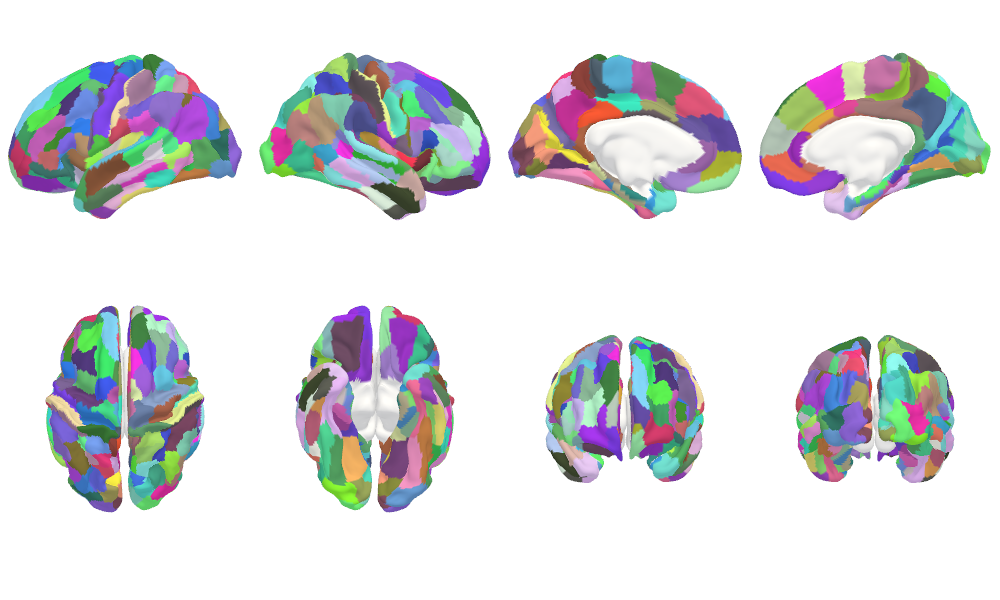

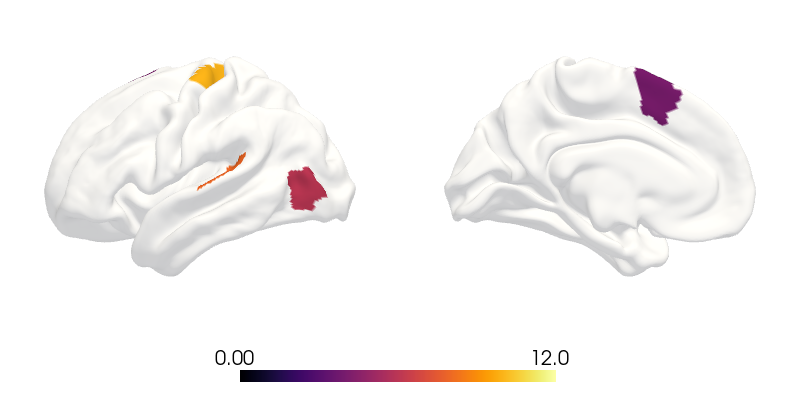

In [40]:
# 1. verify regions loaded correctly
regions = yab.get_atlas_regions(
    atlas=None,
    category='cortical', 
    custom_atlas_path=work_dir
)
print(f"yabplot loaded {len(regions)} regions.")

# 2. plot the atlas
yab.plot_cortical(custom_atlas_path=work_dir)

# 3. plot with test data
test_data = {
    'A4ul_L': 10,       # primary motor (upper limb)
    'A41-42_L': 8,      # auditory cortex (changed / to -)
    'V5-MT+_L': 6,      # visual motion (changed / to -)
    'A8m_L': 4          # medial prefrontal
}
yab.plot_cortical(
    data=test_data,
    custom_atlas_path=work_dir,
    views=['left_lateral', 'left_medial'],
    cmap='inferno',
    vminmax=[0, 12],
    figsize=(800, 400)
)

## plan b: alternative - using existing surface files

the method above is useful when you **only** have a nifti volume. however, many popular atlases (like brainnetome, schaefer, or glasser) have official surface releases (usually `.label.gii` files).

if you have these files, you should use them instead! they are typically generated using advanced "ribbon-constrained" mapping by the authors, which is more accurate than our pure-python approximation.

to use existing surface files with `yabplot`:
1. you do **not** need the mapping or refinement steps above.
2. simply concatenate the left and right hemisphere label data into a single csv.

here is a helper function to do just that:

In [41]:
def generate_vertex_mapping(lh_path, rh_path, output_name):
    """
    combines lh and rh gifti label files into a single integer csv 
    aligned with conte69 (32k_fs_lr) vertices.
    """
    print(f"--- generating atlas map ---")
    
    # 1. load left hemisphere
    gii_lh = nib.load(lh_path)
    # extract the data array and ensure it's integers
    lh_data = gii_lh.darrays[0].data.astype(int).flatten()
    print(f"lh loaded: {len(lh_data)} vertices")

    # 2. load right hemisphere
    gii_rh = nib.load(rh_path)
    rh_data = gii_rh.darrays[0].data.astype(int).flatten()
    print(f"rh loaded: {len(rh_data)} vertices")

    # 3. check compatibility
    # conte69/32k_fs_lr usually has exactly 32492 vertices per hemisphere
    if len(lh_data) != 32492 or len(rh_data) != 32492:
        print("warning: vertex count does not match standard 32k_fs_lr (32492).")
        print("ensure your input files are resampled to the correct mesh density.")

    # 4. concatenate (order must be left then right)
    full_cortex = np.concatenate([lh_data, rh_data])
    
    # 5. save
    os.makedirs(os.path.dirname(output_name), exist_ok=True)
    np.savetxt(output_name, full_cortex, fmt='%i')
    
    print(f"total vertices: {len(full_cortex)}")
    print(f"unique regions found: {len(np.unique(full_cortex)) - 1} (excluding background)")
    print(f"saved to: {output_name}")

# usage example:
# replace these with your actual .label.gii file paths
# lh_file = 'path/to/atlas.L.32k_fs_LR.label.gii'
# rh_file = 'path/to/atlas.R.32k_fs_LR.label.gii'
# generate_vertex_mapping(lh_file, rh_file, 'my_custom_atlas/atlas.csv')